# Decomposition Methods

                   GRP
GRPRatingsDate        
2008-09-28      219.91
2008-10-05      193.84
2008-10-12      201.30
2008-10-19      198.40
2008-10-26      170.74
(72, 1)
                   GRP
GRPRatingsDate        
2008-11-02      206.61
2008-11-09      188.68
2008-11-16      197.64
2008-11-23      193.16
2008-11-30      184.74
(20, 1)


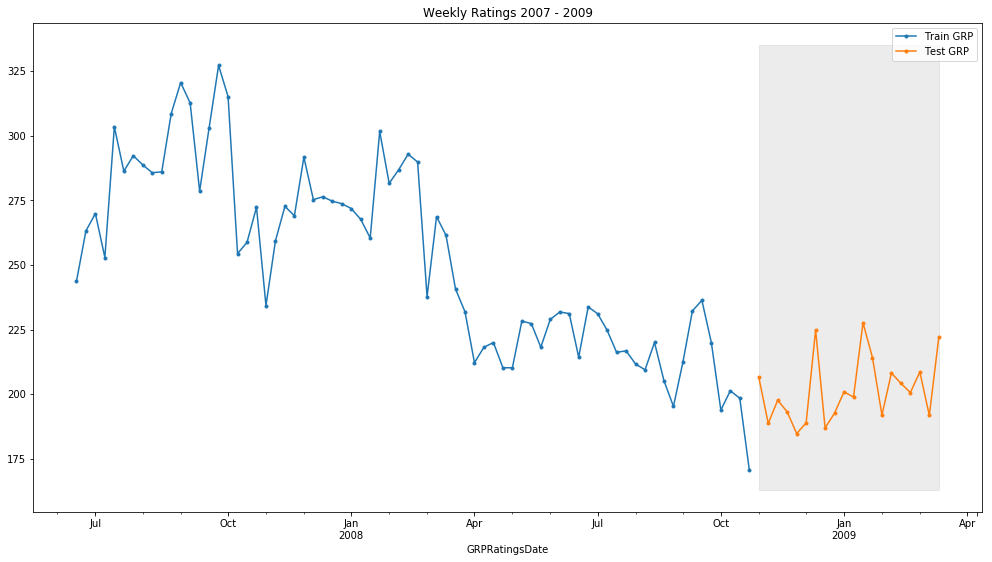

,GRP
GRPRatingsDate,
2009-02-15,204.20
2009-02-22,200.61
2009-03-01,208.56
2009-03-08,191.74
2009-03-15,222.07


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import matplotlib
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import math

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


os.chdir('/Users/pierlim/PycharmProjects/IndianTV')
df = pd.read_csv("./data/ActualRatings_weeklyGRP.csv")
df = df.drop(df.columns[2], axis=1)
split_str = df['GRPRatingsDate'].str.split('(')
df['GRPRatingsDate'] = split_str.str[0]
df['GRPRatingsDate'] = pd.to_datetime(df['GRPRatingsDate'])

# Get train test
df = df.set_index('GRPRatingsDate')
df_train = df[:'2008-10-26']
print(df_train.tail())
print(df_train.shape)
df_train.to_csv('train.csv')

df_test = df['2008-11-1':]
print(df_test.head())
print(df_test.shape)
df_test.to_csv('test.csv')

ax = pd.concat([df_train, df_test], axis=1).plot(style='.-', figsize=(17, 9))
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2008-11-02'), df.index[-1], alpha=.15, zorder=-1, color='grey');
ax.legend(['Train GRP', 'Test GRP'])
plt.title('Weekly Ratings 2007 - 2009')
plt.show()
df.tail()

Observation : The oscillations get less as time progresses, this should be modelled as a multiplicative model.

## Test-Drive Quick Decomposition 

In [53]:
# diff = np.diff(df_train['GRP'])
# print(diff)
ypow = df_train['GRP'] ** 0.7

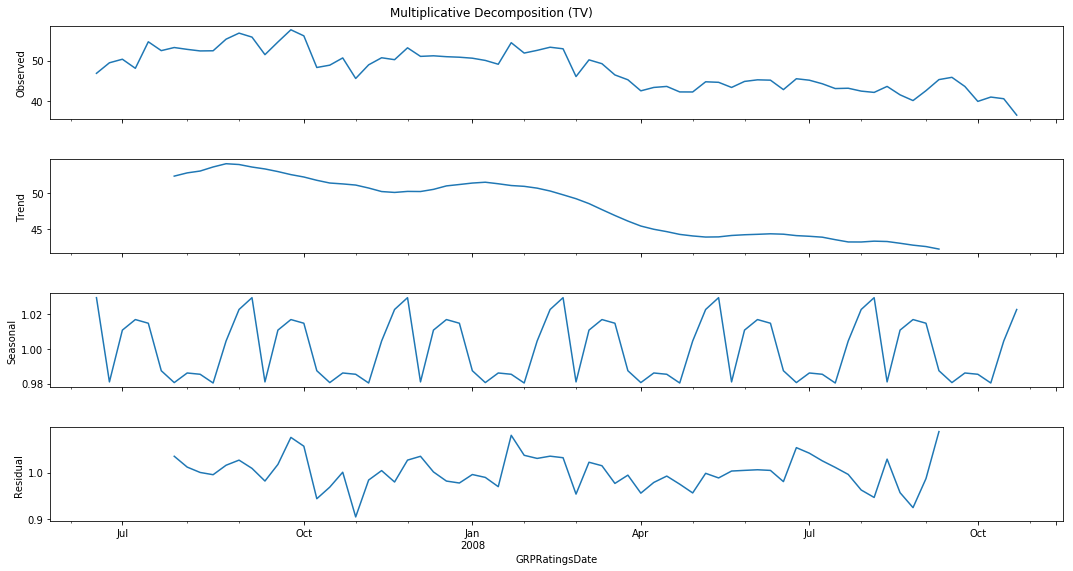

In [54]:
decomp = seasonal_decompose(ypow, freq=12, model='multiplicative')
mplot = decomp.plot()
mplot.set_size_inches(17,9)
plt.suptitle('Multiplicative Decomposition (TV)')
plt.show()


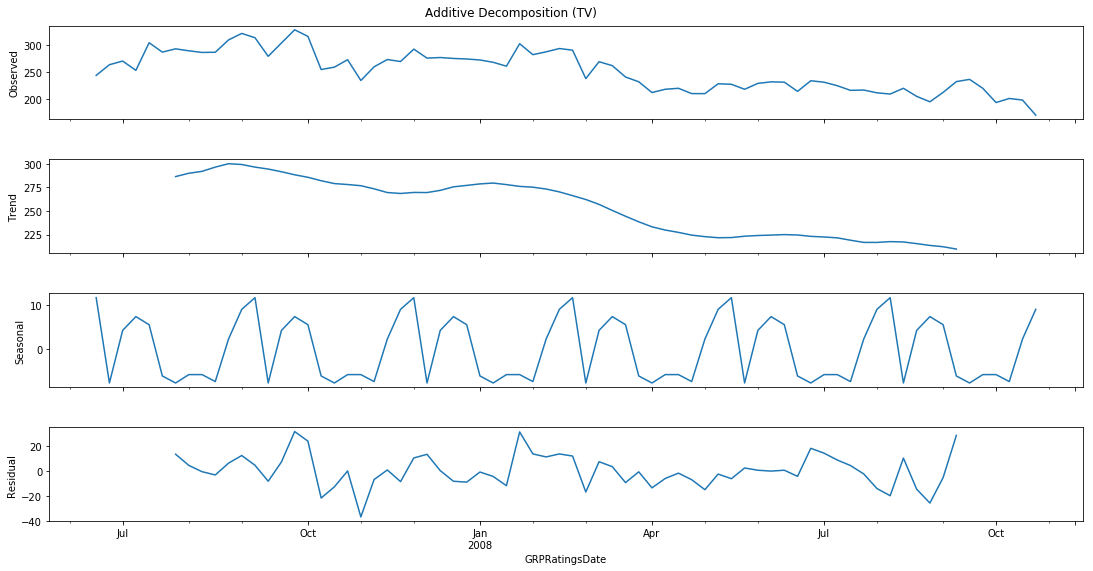

In [55]:
decomp = seasonal_decompose(df_train['GRP'], freq=12, model='additive')
decomp.plot().set_size_inches(17,9)
plt.suptitle('Additive Decomposition (TV)')
plt.show()


# Drill Deeper into Multiplicative

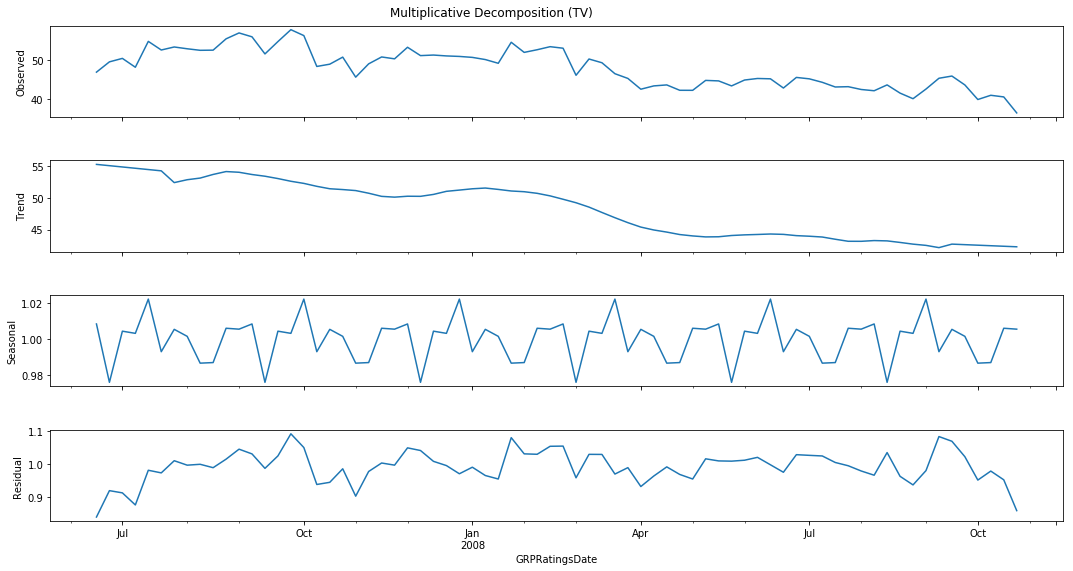

In [56]:
# Try increasing the filter order 

# freq = 18
#filt_fn = np.array([.5] + [1] * (freq - 1) + [.5]) / freq
# filt_fn
freq = 18
ypow = df_train['GRP'] ** 0.7
decomp = seasonal_decompose(ypow, freq=12, model='multiplicative', extrapolate_trend=freq) #,filt=filt_fn, extrapolate_trend=freq)
decomp.plot().set_size_inches(17,9)
plt.suptitle('Multiplicative Decomposition (TV)')
plt.show()

## Try to get a straight trend line (linear)

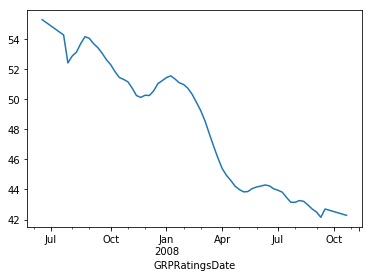

In [57]:
decomp.trend.plot()

Observation : Residual does not seem completely random. Certain peaks are observed to correspond to the peaks in the observed. 

In [58]:
df_trend = pd.DataFrame(decomp.trend)
#df_trend = df_trend.columns = ['GRPRatingsDate', 'Trend']
df_trend.reset_index(level=0, inplace=True)
print(df_trend)
df_trend = df_trend.dropna()
coefs = np.polyfit(df_trend.index, df_trend['GRP'], 1)
coefs

   GRPRatingsDate        GRP
0      2007-06-17  55.305577
1      2007-06-24  55.101795
2      2007-07-01  54.898013
3      2007-07-08  54.694230
4      2007-07-15  54.490448
5      2007-07-22  54.286666
6      2007-07-29  52.425417
7      2007-08-05  52.881718
8      2007-08-12  53.142595
9      2007-08-19  53.715977
10     2007-08-26  54.173089
11     2007-09-02  54.060613
12     2007-09-09  53.705748
13     2007-09-16  53.436329
14     2007-09-23  53.065184
15     2007-09-30  52.637473
16     2007-10-07  52.301759
17     2007-10-14  51.837487
18     2007-10-21  51.454185
19     2007-10-28  51.326270
20     2007-11-04  51.166431
21     2007-11-11  50.747626
22     2007-11-18  50.251241
23     2007-11-25  50.127225
24     2007-12-02  50.271648
25     2007-12-09  50.255443
26     2007-12-16  50.558283
27     2007-12-23  51.047060
28     2007-12-30  51.244160
29     2008-01-06  51.448434
..            ...        ...
42     2008-04-06  45.392311
43     2008-04-13  44.935484
44     2008-04

array([ -0.20420865,  55.52015601])

## Get a linear fit

In [59]:
# Predict trend length of test data steps ahead
predict_trend = []
for x in range(72 , df_test.shape[0]+72, 1):
    #print(x)
    predict_trend.append(coefs[0]*x + coefs[1])
    
# print(predict_trend)
# len(predict_trend)

## Handle Seasonal Component

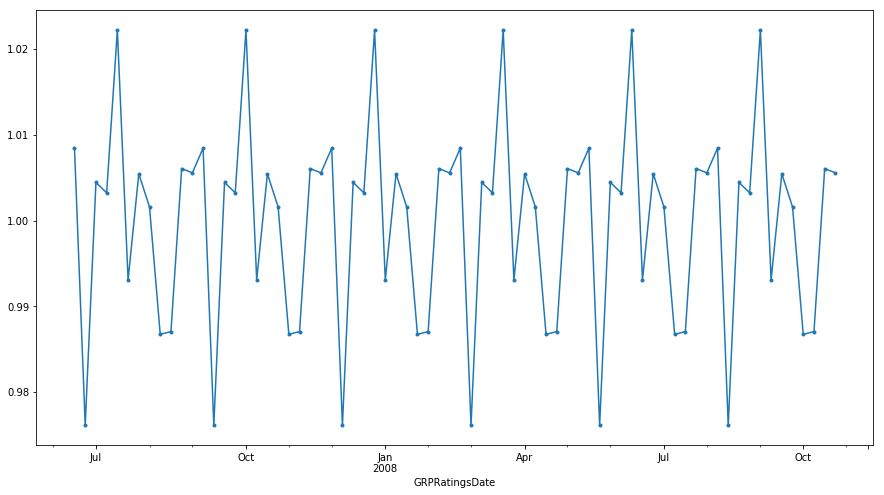

In [60]:
decomp.seasonal.plot(style='.-', figsize=(15,8))




Seasonal is 7 points here, we just have to repeat multiple steps. 

In [61]:
one_season = decomp.seasonal[0:12]
print(one_season)

GRPRatingsDate
2007-06-17    1.008446
2007-06-24    0.976104
2007-07-01    1.004446
2007-07-08    1.003243
2007-07-15    1.022219
2007-07-22    0.993080
2007-07-29    1.005462
2007-08-05    1.001586
2007-08-12    0.986730
2007-08-19    0.987050
2007-08-26    1.006070
2007-09-02    1.005564
Name: GRP, dtype: float64


In [62]:
# start_idx = 2 # next part of the graph should start at index 2 (visually observed)
# yhat = []
# count = 0
# while (count < 20):
#     yhat.append(one_season[start_idx])
#     start_idx = (start_idx + 1) % 7
#     count = count + 1
start_idx = 0 # next part of the graph should start at index 2 (visually observed)
yhat = []
count = 0
while (count < 20):
    yhat.append(one_season[start_idx])
    start_idx = (start_idx + 1) % 12
    count = count + 1

    
print(yhat)

[1.0084457154246342, 0.97610449313204495, 1.004445945641377, 1.0032430888268598, 1.0222187593405965, 0.99308025672266975, 1.005462192085731, 1.0015864097738891, 0.98673026901685468, 0.98704960107615114, 1.0060697197551853, 1.0055635492040058, 1.0084457154246342, 0.97610449313204495, 1.004445945641377, 1.0032430888268598, 1.0222187593405965, 0.99308025672266975, 1.005462192085731, 1.0015864097738891]


In [63]:
# Multiplicative, so season times trend
yhat_result = np.asarray(yhat) * np.asarray(predict_trend)
yhat_result

yhat_result = yhat_result ** (1/0.7)


Add random noise according to specs of the residual

In [64]:

# import numpy as np

# res = decomp.resid
# print(res)

# print(np.mean(res))
# print(np.std(res)*np.std(res))
# samples = np.random.normal(np.mean(res), np.std(res), size=len(yhat_result))

# plt.plot(samples)
# plt.show()

# yhat_result = yhat_result * samples


In [65]:
mae = mean_absolute_error(df_test['GRP'], yhat_result)
mse = mean_squared_error(df_test['GRP'], yhat_result)
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE),  ({:.2f} MAE)'.format(mse, math.sqrt(mse), mae))
mape = mean_absolute_percentage_error(df_test['GRP'], yhat_result)
print('Prediction quality: {:.2f}% MAPE '.format(mape))

Prediction quality: 497.68 MSE (22.31 RMSE),  (17.70 MAE)
Prediction quality: 8.48% MAPE 


# Drill Deeper into Additive

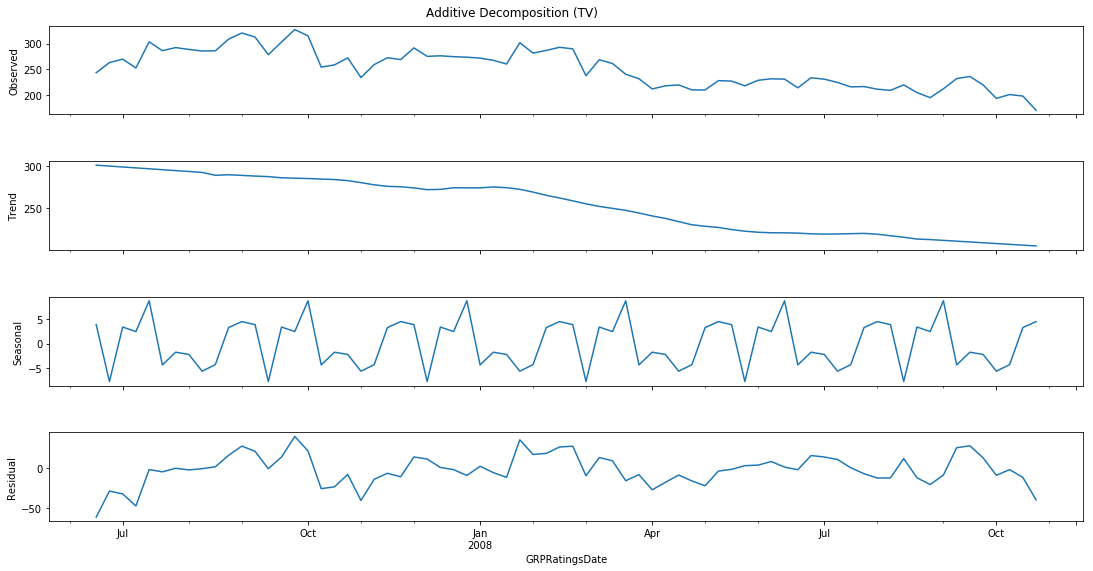

In [142]:
# Try increasing the filter order 

freq = 18
filt_fn = np.array([.5] + [1] * (freq - 1) + [.5]) / freq
filt_fn
decomp = seasonal_decompose(df_train['GRP'], freq=12, model='additive', filt=filt_fn, extrapolate_trend=freq)
decomp.plot().set_size_inches(17,9)
plt.suptitle('Additive Decomposition (TV)')
plt.show()

   GRPRatingsDate         GRP
0      2007-06-17  300.808342
1      2007-06-24  299.746668
2      2007-07-01  298.684993
3      2007-07-08  297.623319
4      2007-07-15  296.561644
5      2007-07-22  295.499970
6      2007-07-29  294.438295
7      2007-08-05  293.376621
8      2007-08-12  292.314946
9      2007-08-19  288.878056
10     2007-08-26  289.552778
11     2007-09-02  288.817500
12     2007-09-09  288.007500
13     2007-09-16  287.331944
14     2007-09-23  285.997222
15     2007-09-30  285.502222
16     2007-10-07  285.113611
17     2007-10-14  284.481667
18     2007-10-21  283.908056
19     2007-10-28  282.624167
20     2007-11-04  280.301389
21     2007-11-11  277.696667
22     2007-11-18  275.941944
23     2007-11-25  275.399722
24     2007-12-02  274.093889
25     2007-12-09  272.040000
26     2007-12-16  272.322222
27     2007-12-23  274.255278
28     2007-12-30  274.158056
29     2008-01-06  274.153056
..            ...         ...
42     2008-04-06  241.113611
43     200

array([  -1.49597929,  307.08015896])

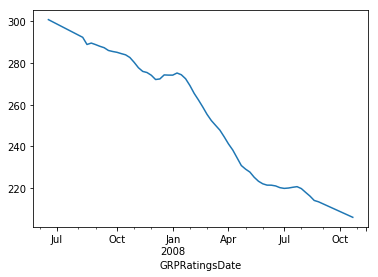

In [143]:
decomp.trend.plot()
df_trend = pd.DataFrame(decomp.trend)
#df_trend = df_trend.columns = ['GRPRatingsDate', 'Trend']
df_trend.reset_index(level=0, inplace=True)
print(df_trend)
df_trend = df_trend.dropna()
coefs = np.polyfit(df_trend.index, df_trend['GRP'], 1)
coefs

In [144]:
# Predict trend length of test data steps ahead
predict_trend = []
for x in range(72 , df_test.shape[0]+72, 1):
    #print(x)
    predict_trend.append(coefs[0]*x + coefs[1])

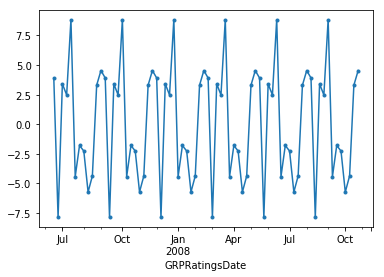

In [145]:
decomp.seasonal.plot(style='.-')

In [146]:
# one_season = decomp.seasonal[0:7]
# print(one_season)
# start_idx = 2 # next part of the graph should start at index 2 (visually observed)
# yhat = []
# count = 0
# while (count < 20):
#     yhat.append(one_season[start_idx])
#     start_idx = (start_idx + 1) % 7
#     count = count + 1
one_season = decomp.seasonal[0:12]
print(one_season)
start_idx = 0 # next part of the graph should start at index 2 (visually observed)
yhat = []
count = 0
while (count < 20):
    yhat.append(one_season[start_idx])
    start_idx = (start_idx + 1) % 12
    count = count + 1
    
print(yhat)

GRPRatingsDate
2007-06-17    3.902846
2007-06-24   -7.861180
2007-07-01    3.405025
2007-07-08    2.472061
2007-07-15    8.828871
2007-07-22   -4.419967
2007-07-29   -1.797508
2007-08-05   -2.262458
2007-08-12   -5.723888
2007-08-19   -4.367968
2007-08-26    3.292452
2007-09-02    4.531714
Name: GRP, dtype: float64
[3.9028463084795373, -7.8611801697530908, 3.4050248334957756, 2.472061464424947, 8.8288714871669765, -4.4199666382391278, -1.7975084673489214, -2.2624577038661537, -5.723888421864844, -4.3679682626705407, 3.2924515716374221, 4.5317139985380219, 3.9028463084795373, -7.8611801697530908, 3.4050248334957756, 2.472061464424947, 8.8288714871669765, -4.4199666382391278, -1.7975084673489214, -2.2624577038661537]


In [147]:
# Additive, so season plus trend
yhat_result = np.asarray(yhat) + np.asarray(predict_trend)
yhat_result = pd.DataFrame(yhat_result)
print(yhat_result)
df_test.reset_index(level=0, inplace=True)
df_test = df_test.drop('GRPRatingsDate', axis=1)
print(df_test)
pd.concat([df_test, yhat_result], axis=1).plot()

             0
0   203.272496
1   190.012490
2   199.782716
3   197.353773
4   202.214604
5   187.469787
6   188.596266
7   186.635337
8   181.677927
9   181.537868
10  187.702309
11  187.445592
12  185.320745
13  172.060739
14  181.830965
15  179.402022
16  184.262853
17  169.518035
18  170.644514
19  168.683586


ValueError: labels ['GRPRatingsDate'] not contained in axis

In [148]:
df_test

,index,GRP
0,0,206.61
1,1,188.68
2,2,197.64
3,3,193.16
4,4,184.74
5,5,188.88
6,6,224.85
7,7,186.91
8,8,192.65
9,9,200.88


In [149]:
mae = mean_absolute_error(df_test['GRP'], yhat_result)
mse = mean_squared_error(df_test['GRP'], yhat_result)
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE),  ({:.2f} MAE)'.format(mse, math.sqrt(mse), mae))
mape = mean_absolute_percentage_error(df_test['GRP'], yhat_result)
print('Prediction quality: {:.2f}% MAPE '.format(mape))

Prediction quality: 575.50 MSE (23.99 RMSE),  (18.89 MAE)
Prediction quality: 8.85% MAPE 


## Try quadratic trend fitting

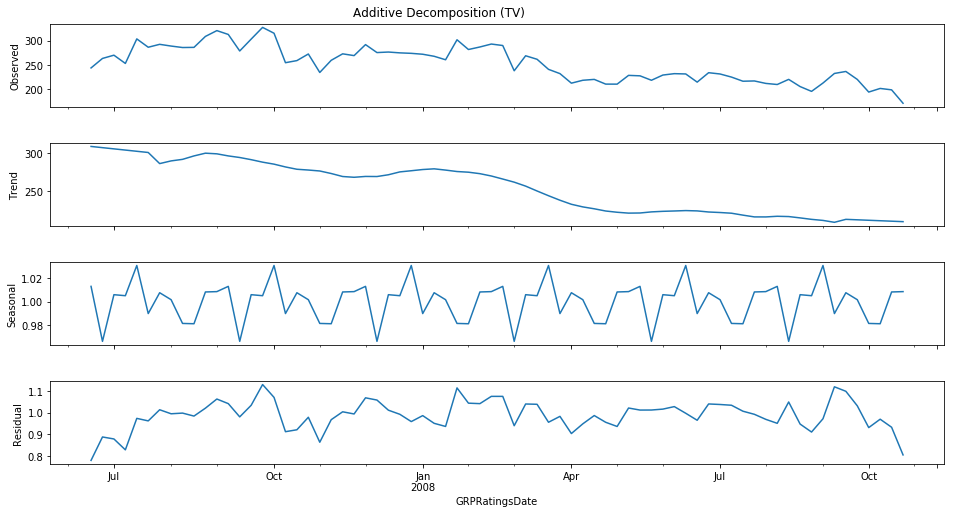

In [150]:
decomp = seasonal_decompose(df_train['GRP'], freq=12, model='multiplicative', extrapolate_trend=freq)
decomp.plot().set_size_inches(15,8)
plt.suptitle('Additive Decomposition (TV)')
plt.show()


   GRPRatingsDate         GRP
0      2007-06-17  308.716579
1      2007-06-24  307.136567
2      2007-07-01  305.556556
3      2007-07-08  303.976544
4      2007-07-15  302.396532
5      2007-07-22  300.816520
6      2007-07-29  286.309583
7      2007-08-05  289.828750
8      2007-08-12  291.852083
9      2007-08-19  296.331667
10     2007-08-26  299.915833
11     2007-09-02  299.073333
12     2007-09-09  296.346250
13     2007-09-16  294.266250
14     2007-09-23  291.440833
15     2007-09-30  288.186667
16     2007-10-07  285.579167
17     2007-10-14  281.935000
18     2007-10-21  278.914583
19     2007-10-28  277.904583
20     2007-11-04  276.655833
21     2007-11-11  273.355000
22     2007-11-18  269.439167
23     2007-11-25  268.439583
24     2007-12-02  269.537500
25     2007-12-09  269.412500
26     2007-12-16  271.725417
27     2007-12-23  275.461250
28     2007-12-30  276.977917
29     2008-01-06  278.560833
..            ...         ...
42     2008-04-06  233.166667
43     200

array([  9.44884500e-04,  -1.60414890e+00,   3.10407203e+02])

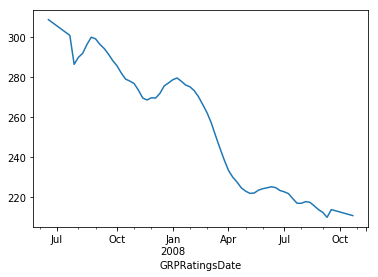

In [151]:
decomp.trend.plot()
df_trend = pd.DataFrame(decomp.trend)
#df_trend = df_trend.columns = ['GRPRatingsDate', 'Trend']
df_trend.reset_index(level=0, inplace=True)
print(df_trend)
df_trend = df_trend.dropna()
coefs = np.polyfit(df_trend.index, df_trend['GRP'], 2)
coefs

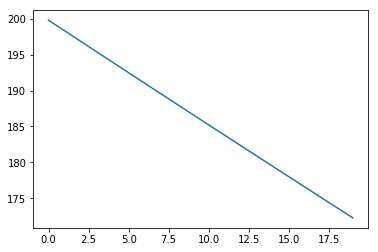

In [154]:
# Predict trend length of test data steps ahead
predict_trend = []
for x in range(72 , df_test.shape[0]+72, 1):
    #print(x)
    predict_trend.append(coefs[0]*x*x + coefs[1]*x + coefs[2])
    
plt.plot(predict_trend)

It's a straight line! x^2 coefficient is especially small, no wonder. 

In [90]:
one_season = decomp.seasonal[0:12]
print(one_season)
start_idx = 0 # next part of the graph should start at index 2 (visually observed)
yhat = []
count = 0
while (count < 20):
    yhat.append(one_season[start_idx])
    start_idx = (start_idx + 1) % 12
    count = count + 1

print(yhat)

GRPRatingsDate
2007-06-17    1.013185
2007-06-24    0.965889
2007-07-01    1.006029
2007-07-08    1.005153
2007-07-15    1.031141
2007-07-22    0.989788
2007-07-29    1.007714
2007-08-05    1.001719
2007-08-12    0.981304
2007-08-19    0.981041
2007-08-26    1.008367
2007-09-02    1.008671
Name: GRP, dtype: float64
[1.013184523028746, 0.96588947213372489, 1.0060287667722558, 1.0051526045856911, 1.0311406735186699, 0.989787940854016, 1.0077139217265556, 1.001719326228512, 0.98130368022639169, 0.98104124544624105, 1.0083672802756301, 1.0086705652035661, 1.013184523028746, 0.96588947213372489, 1.0060287667722558, 1.0051526045856911, 1.0311406735186699, 0.989787940854016, 1.0077139217265556, 1.001719326228512]


In [91]:
# Multiplicative, so season times trend
yhat_result = np.asarray(yhat) * np.asarray(predict_trend)
yhat_result

array([ 202.44112034,  191.57415359,  198.06128161,  196.4178865 ,
        199.98925878,  190.52423908,  192.50587406,  189.90240786,
        184.60535243,  183.13148857,  186.77018756,  185.36556207,
        184.72967915,  174.71137913,  180.52055782,  178.9152332 ,
        182.05746043,  173.33402091,  175.0271772 ,  172.55040288])

In [92]:
mae = mean_absolute_error(df_test['GRP'], yhat_result)
mse = mean_squared_error(df_test['GRP'], yhat_result)
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE),  ({:.2f} MAE)'.format(mse, math.sqrt(mse), mae))
mape = mean_absolute_percentage_error(df_test['GRP'], yhat_result)
print('Prediction quality: {:.2f}% MAPE '.format(mape))

Prediction quality: 525.98 MSE (22.93 RMSE),  (18.13 MAE)
Prediction quality: 8.69% MAPE 


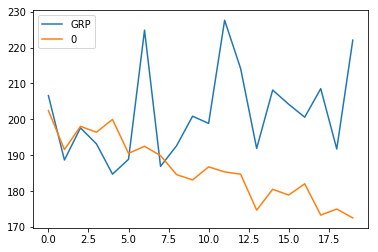

In [93]:
pd.concat([df_test['GRP'], pd.DataFrame(yhat_result)], axis=1).plot()

Very small improvement, do we bother? 